In [103]:
# ! pip install pydicom
# ! pip install scikit-image

import pandas as pd
import pydicom
import glob as glb
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.ndimage import zoom

from skimage import measure


In [39]:
%matplotlib notebook

In [13]:
dicom_folder = './DICOM_data/*.dcm'
files = glb.glob(dicom_folder) # get dir of all the dicom fules

In [27]:
dicom_datasets = [] # Storage for all files
for file in files[1:]:
    dicom_dataset = pydicom.dcmread(file)
    dicom_datasets.append(dicom_dataset)

In [28]:
dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 222
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.93764.30000020032604322280800012613
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
(0002, 0016) Source Application Entity Title     AE: 'AN_CTAWP93764'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.

In [32]:
rows = int(dataset.Rows)
columns = int(dataset.Columns)
ct_scan = np.zeros((len(files), rows, columns), dtype=np.int16)
for i, dataset in enumerate(dicom_datasets):
    ct_scan[i, :, :] = dataset.pixel_array

<IPython.core.display.Javascript object>


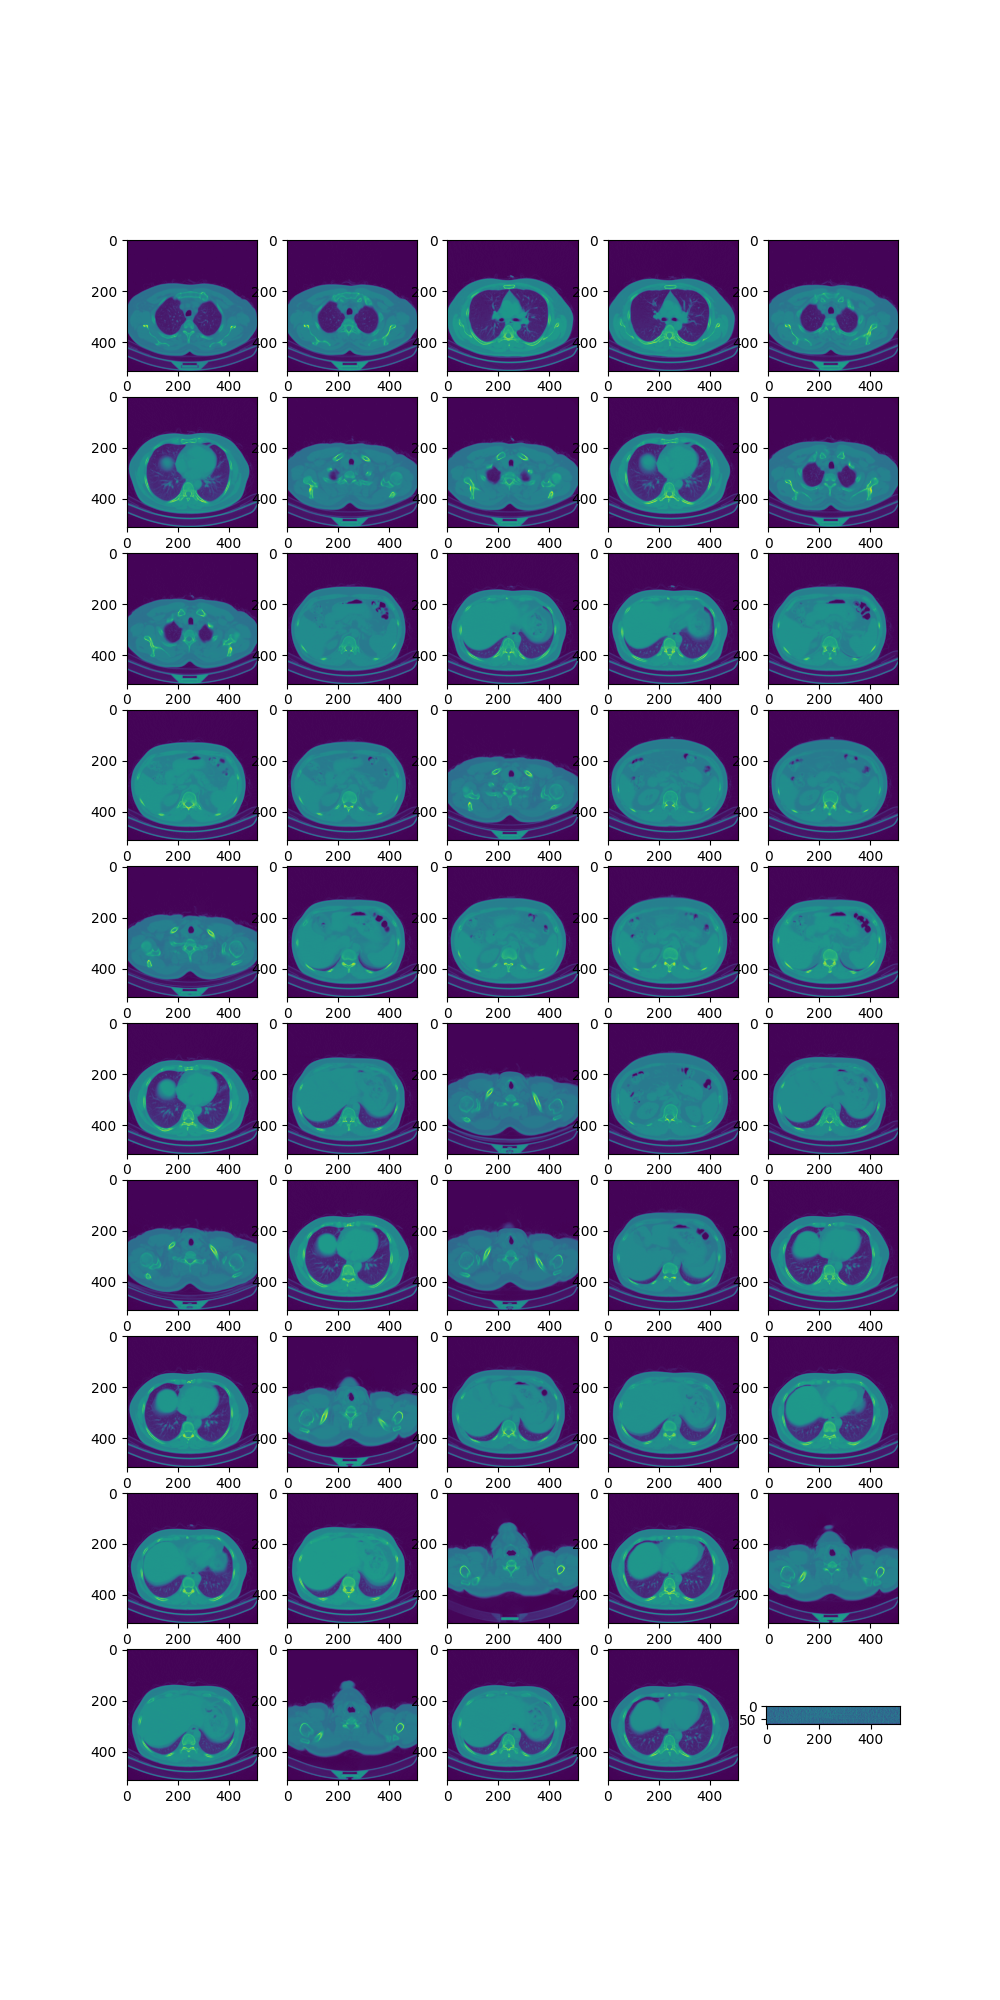

In [56]:
f,ax = plt.subplots(10,5,figsize=(10,20))
axs = ax.ravel()
for i in range(10*5):
    axs[i].imshow(ct_scan[i, :, :], cmap='viridis')

<IPython.core.display.Javascript object>


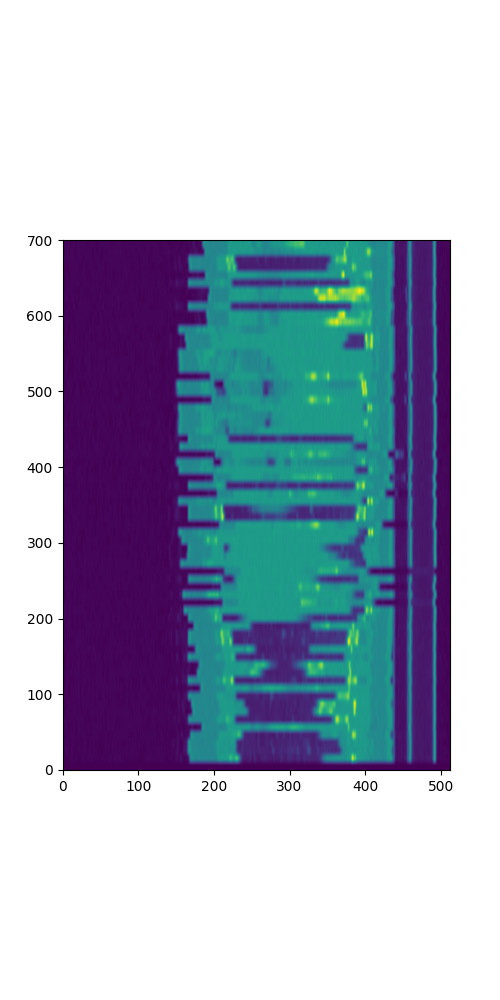

In [69]:
# Side view
f,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(ct_scan[:, :,100], cmap='viridis',extent=[0,512, 0, 700])

In [114]:
# Define the downsampling factor
downsampling_factor = 3

# Downsize the CT scan
downsized_ct_scan = zoom(ct_scan, (1 / downsampling_factor, 1 / downsampling_factor, 1 / downsampling_factor))

# Define the iso-value for the iso-surface
iso_value = 1000  # Adjust as needed

# Extract iso-surface using marching cubes algorithm
verts, faces, _, _ = measure.marching_cubes(downsized_ct_scan, iso_value, spacing=(1, 1, 1))


In [115]:
threshold_values = range(200, 801, 100)

# Initialize lists to store vertices and faces for each iso-surface
all_verts = []
all_faces = []

# Extract iso-surfaces for each threshold value
for iso_value in threshold_values:
    verts, faces, _, _ = measure.marching_cubes(downsized_ct_scan, iso_value, spacing=(1, 1, 1))
    all_verts.append(verts)
    all_faces.append(faces)

# Create a 3D plot using Matplotlib
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each iso-surface using triangles with different colors
for verts, faces, iso_value in zip(all_verts, all_faces, threshold_values):
    mesh = Poly3DCollection(verts[faces], alpha=0.1, linewidths=0.2, edgecolors='r')
    ax.add_collection3d(mesh)

    # Add a label to indicate the iso-value
    ax.text(0, 0, iso_value, f'Iso-value: {iso_value}', color='r')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the 3D plot
plt.show()

<IPython.core.display.Javascript object>

In [112]:
# Specify the path to the output OBJ file
obj_filename = 'isoSurface.obj'  # Replace with your desired file path

# Export the mesh to the OBJ file
with open(obj_filename, 'w') as obj_file:
    # Write vertices to the OBJ file
    for vertex in verts:
        obj_file.write(f'v {vertex[0]} {vertex[1]} {vertex[2]}\n')

    # Write faces to the OBJ file (faces are 1-based indices)
    for face in faces:
        obj_file.write(f'f {face[0]+1} {face[1]+1} {face[2]+1}\n')

print(f'Mesh exported to {obj_filename}')

Mesh exported to isoSurface.obj
